***Install dependencies***

In [ ]:

!pip install -q datasets albumentations opencv-python pytorch-lightning torchmetrics

***Load HF dataset, parse OCR boxes into polygons, and split into train/val***

In [ ]:


from datasets import load_dataset
import json

# Load raw "train" split from HF
raw_dataset = load_dataset("mychen76/invoices-and-receipts_ocr_v1", split="train")

def prepare_dbnet(example):
    raw = json.loads(example["raw_data"])
    boxes = eval(raw["ocr_boxes"])   # list of (box, (text, conf))

    polygons = []
    for box, (text, conf) in boxes:
        flat = []
        for point in box:
            flat += [point[0], point[1]]
        polygons.append({"text": text, "poly": flat})

    example["polygons"] = polygons
    return example

# Apply preprocessing (adds "polygons" field)
dataset = raw_dataset.map(prepare_dbnet)

# Create train/val split (e.g., 80% train, 20% val)
splits = dataset.train_test_split(test_size=0.2, seed=42)
train_hf = splits["train"]
val_hf   = splits["test"]

print("Train size:", len(train_hf))
print("Val size:", len(val_hf))


Train size: 1634
Val size: 409


***Define DBNet model with ResNet18 backbone***

In [ ]:


import torch
import torch.nn as nn
import torchvision.models as models

class DBNet(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        # Keep only convolutional layers
        self.backbone = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool,
            backbone.layer1,
            backbone.layer2,
            backbone.layer3,
            backbone.layer4
        )
        self.conv = nn.Conv2d(512, 64, kernel_size=1)    # 512 for ResNet18
        self.binarize = nn.Conv2d(64, 1, 3, padding=1)   # raw logits

    def forward(self, x):
        f = self.backbone(x)  # [B, 512, H/32, W/32]
        f = self.conv(f)
        prob_map = self.binarize(f)  # [B, 1, H/32, W/32]
        return prob_map


*** Loss function for DBNet***

In [ ]:
import torch.nn as nn


db_loss = nn.BCEWithLogitsLoss()


***Image transform and mask creation from polygons***

In [ ]:


from torchvision import transforms
from PIL import Image, ImageDraw
import numpy as np

# Image transform
base_transform = transforms.Compose([
    transforms.Resize((640, 480)),  # (height, width)
    transforms.ToTensor()
])

def create_mask_from_polygons(polygons, image_size):
    """
    polygons: list of polygons, each is [x1, y1, x2, y2, ...]
    image_size: (width, height)
    """
    mask = Image.new("L", image_size, 0)
    draw = ImageDraw.Draw(mask)

    for poly in polygons:
        # poly is flat [x1, y1, x2, y2, ...]
        # PIL expects list of (x,y) pairs
        xs = poly[0::2]
        ys = poly[1::2]
        pts = list(zip(xs, ys))
        draw.polygon(pts, fill=255)

    mask = np.array(mask) / 255.0  # [H, W] in {0,1}
    return torch.tensor(mask, dtype=torch.float32)


***DBNetDataset to resize images and build full-res masks***

In [ ]:


import torch
from torch.utils.data import Dataset

class DBNetDataset(Dataset):
    def __init__(self, ds):
        self.ds = ds

        # target size (H, W) because torchvision.Resize takes (height, width)
        self.target_h = 1024  # New target height
        self.target_w = 768   # New target width

        self.transform = transforms.Compose([
            transforms.Resize((self.target_h, self.target_w)),  # (H, W)
            transforms.ToTensor()
        ])

    def __getitem__(self, idx):
        ex = self.ds[idx]
        pil_img = ex["image"]              # PIL image

        # original size (width, height)
        orig_w, orig_h = pil_img.size

        # 1) Resize image
        img = self.transform(pil_img)      # [3, 640, 480]

        # 2) Scale factors from original → resized
        sx = self.target_w / orig_w       # scale for x (width)
        sy = self.target_h / orig_h       # scale for y (height)

        # 3) Extract & SCALE polygons
        polygons_raw = [p["poly"] for p in ex.get("polygons", [])]
        scaled_polygons = []
        for poly in polygons_raw:
            scaled = []
            xs = poly[0::2]
            ys = poly[1::2]
            for x, y in zip(xs, ys):
                scaled_x = x * sx
                scaled_y = y * sy
                scaled += [scaled_x, scaled_y]
            scaled_polygons.append(scaled)

        # 4) Create mask on resized image size (width, height)
        mask = create_mask_from_polygons(
            scaled_polygons,
            (self.target_w, self.target_h)  # (width, height)
        )                                  # -> [H, W]
        mask = mask.unsqueeze(0)           # [1, H, W]

        return img, mask                   # img: [3,H,W], mask: [1,H,W]

    def __len__(self):
        return len(self.ds)


***Create train/val DBNetDataset and DataLoaders***

In [ ]:


from torch.utils.data import DataLoader

train_ds = DBNetDataset(train_hf)
val_ds   = DBNetDataset(val_hf)

train_loader = DataLoader(
    train_ds,
    batch_size=1,
    shuffle=True,
    num_workers=0,   # safer in Colab
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


Train batches: 1634
Val batches: 409


***Sanity check – visualize one resized image + its GT mask***

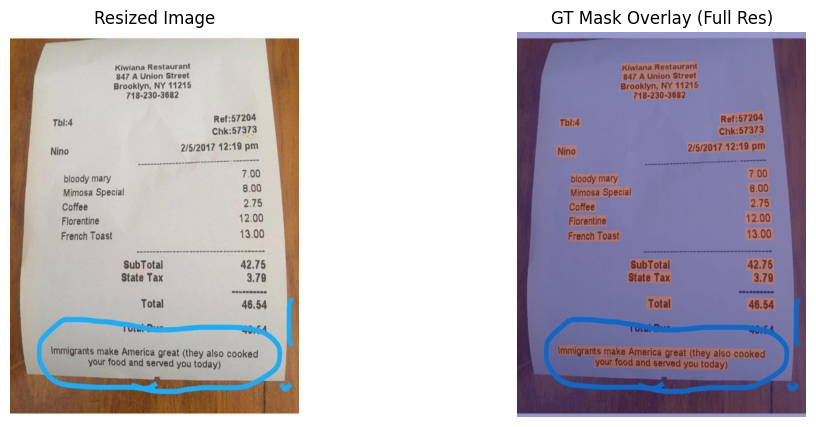

In [ ]:


import matplotlib.pyplot as plt

ds_vis = train_ds   # or val_ds if you want

ex_img, ex_mask = ds_vis[0]      # ex_mask: [1, H, W]
mask_np = ex_mask[0].cpu().numpy()
img_np = ex_img.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Resized Image")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("GT Mask Overlay (Full Res)")
plt.imshow(img_np)
plt.imshow(mask_np, cmap="jet", alpha=0.4)
plt.axis("off")

plt.show()


***Prepare model, optimizer, and AMP scaler***

In [ ]:


import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = DBNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()

# Get target size from dataset (should be 640 x 480)
H = train_loader.dataset.target_h
W = train_loader.dataset.target_w


Using device: cuda


/tmp/ipython-input-437170678.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


***Train the model and save it in Google Drive***

In [ ]:
import time
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.amp import GradScaler, autocast     # new correct AMP import

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DBNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scaler = GradScaler(device.type)

# Remove 'verbose' → not supported in your PyTorch version
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

best_val_loss = float("inf")

# --------- Mount Google Drive BEFORE training ---------
from google.colab import drive
drive.mount('/content/drive')

# Create model directory inside Drive
!mkdir -p /content/drive/MyDrive/model

# Path where best model will be saved directly
best_model_path = "/content/drive/MyDrive/model/dbnet_invoice_trainValSplit_best2.pth"

patience = 3
wait = 0

H = train_loader.dataset.target_h
W = train_loader.dataset.target_w

num_epochs = 20
for epoch in range(num_epochs):
    t0 = time.time()
    model.train()
    train_loss = 0.0

    for imgs, masks in train_loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        optimizer.zero_grad()

        with autocast(device_type=device.type):
            preds = model(imgs)
            preds_up = F.interpolate(preds, size=(H, W), mode="bilinear", align_corners=False)
            loss = db_loss(preds_up, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            preds = model(imgs)
            preds_up = F.interpolate(preds, size=(H, W), mode="bilinear", align_corners=False)
            loss = db_loss(preds_up, masks)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    # Scheduler step
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {time.time()-t0:.1f}s")

    # Save best model
    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_path)
        print(f"  ✅ New best model saved (val_loss={val_loss:.4f})")
        wait = 0
    else:
        wait += 1
        print(f"  ✳️ No improvement. patience {wait}/{patience}")

    if wait >= patience:
        print("Early stopping triggered. Restoring best model.")
        model.load_state_dict(torch.load(best_path, map_location=device))
        break

print("Training finished. Best val loss:", best_val_loss)


Mounted at /content/drive
Epoch 01 | Train Loss: 0.1599 | Val Loss: 0.1570 | Time: 156.6s
  ✅ New best model saved (val_loss=0.1570)
Epoch 02 | Train Loss: 0.1397 | Val Loss: 0.1559 | Time: 155.5s
  ✅ New best model saved (val_loss=0.1559)
Epoch 03 | Train Loss: 0.1347 | Val Loss: 0.1552 | Time: 155.4s
  ✅ New best model saved (val_loss=0.1552)
Epoch 04 | Train Loss: 0.1318 | Val Loss: 0.1764 | Time: 156.7s
  ✳️ No improvement. patience 1/3
Epoch 05 | Train Loss: 0.1295 | Val Loss: 0.1563 | Time: 155.0s
  ✳️ No improvement. patience 2/3
Epoch 06 | Train Loss: 0.1260 | Val Loss: 0.1540 | Time: 154.9s
  ✅ New best model saved (val_loss=0.1540)
Epoch 07 | Train Loss: 0.1225 | Val Loss: 0.1782 | Time: 155.4s
  ✳️ No improvement. patience 1/3
Epoch 08 | Train Loss: 0.1203 | Val Loss: 0.1710 | Time: 154.2s
  ✳️ No improvement. patience 2/3
Epoch 09 | Train Loss: 0.1168 | Val Loss: 0.1548 | Time: 153.7s
  ✳️ No improvement. patience 3/3
Early stopping triggered. Restoring best model.
Training

***Load the BEST saved model from Google Drive for inference***

In [ ]:


from google.colab import drive
drive.mount('/content/drive')

best_model_path = "/content/drive/MyDrive/model/dbnet_invoice_trainValSplit_best3.pth"

best_model = DBNet().to(device)
state_dict = torch.load(best_model_path, map_location=device)
best_model.load_state_dict(state_dict)
best_model.eval()

print("✅ Best model loaded for inference from:")
print(best_model_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Best model loaded for inference from:
/content/drive/MyDrive/model/dbnet_invoice_trainValSplit_best3.pth


***Visualizing Model Predictions vs Ground Truth***

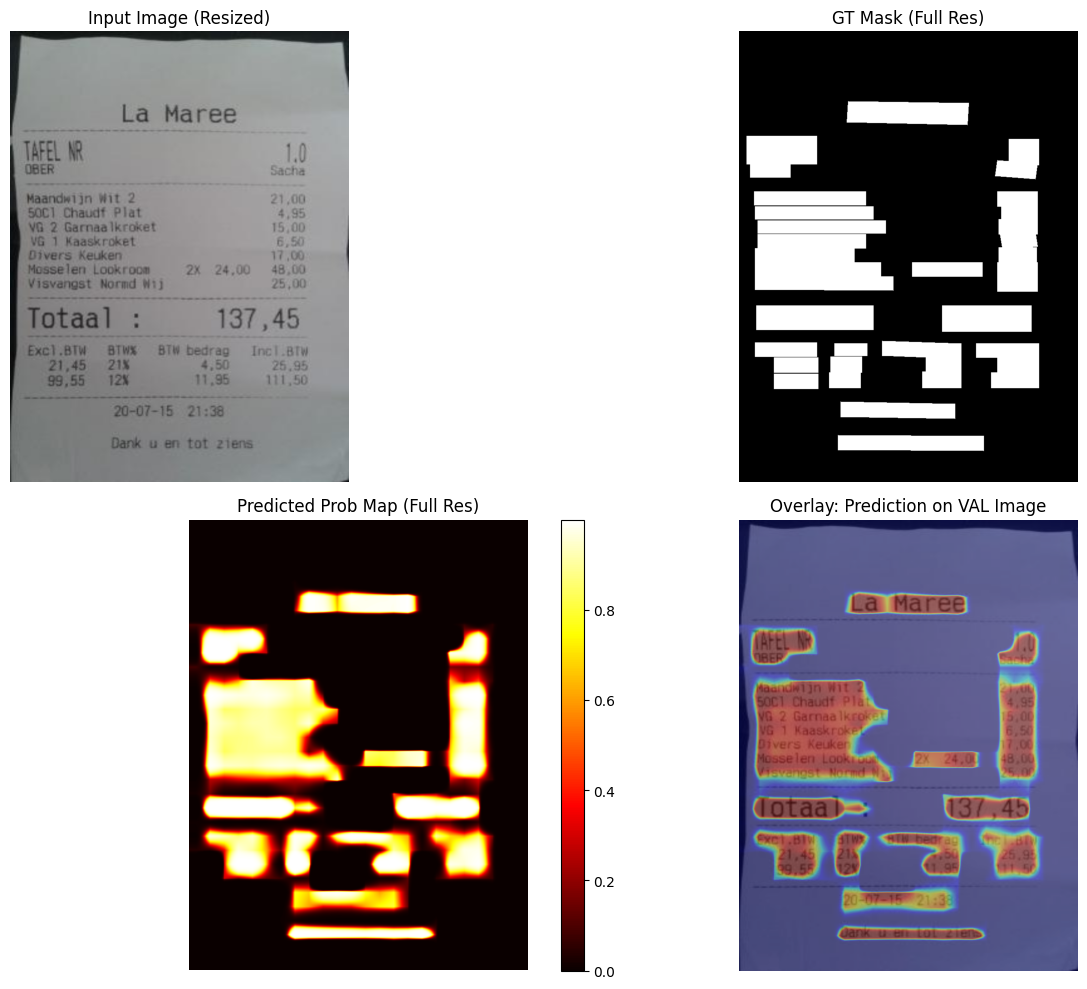

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

vis_dataset = val_loader.dataset
idx = 1
img, gt_mask = vis_dataset[idx]
img_batch = img.unsqueeze(0).to(device)
H, W = img.shape[1], img.shape[2]

with torch.no_grad():
    pred_logits = best_model(img_batch)   # use the model object
    pred_logits_up = F.interpolate(pred_logits, size=(H, W), mode="bilinear", align_corners=False)
    pred_prob = torch.sigmoid(pred_logits_up)[0, 0].cpu().numpy()

gt_np = gt_mask[0].cpu().numpy()
img_np = img.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(16,10))
plt.subplot(2,2,1); plt.title("Input Image (Resized)"); plt.imshow(img_np); plt.axis("off")
plt.subplot(2,2,2); plt.title("GT Mask (Full Res)"); plt.imshow(gt_np, cmap="gray"); plt.axis("off")
plt.subplot(2,2,3); plt.title("Predicted Prob Map (Full Res)"); plt.imshow(pred_prob, cmap="hot"); plt.colorbar(fraction=0.046, pad=0.04); plt.axis("off")
plt.subplot(2,2,4); plt.title("Overlay: Prediction on VAL Image"); plt.imshow(img_np); plt.imshow(pred_prob, cmap="jet", alpha=0.4); plt.axis("off")
plt.tight_layout(); plt.show()


***Full-Resolution Text Extraction Using DBNet + EasyOCR***

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteEasyOCR initialized. GPU: True
Original Image Size: 868x1600
Contours found: 11
OCR result for crop: ['#*****your I(roger SAVINGS TOday****rr', 'MFG CPN SAV [NGS', '16,00', 'STR CPN', '8', 'Kiro', 'PLUS SAVINGS', '5', '17.96', 'TOTAL COUPONS', '$', '33. 96', 'TOTAL', 'SAVINIS ( 94 Pct', '', '$', '33. 96', '#*xxx*your KKROGEr SAVINGS Today*xrrr*']
OCR result for crop: ['4', '49', 'T', '4,00 -', '4,00 -', '4,00-', '4.00-', '1 , 08', '3.04', '4.00', '0', '96', '8']
OCR result for crop: ['']
OCR result for crop: ['00', 'OL']
OCR result for crop: ['4', '49', '0,00', '4', '49', '0,00']
OCR result for crop: ['4', '49', '0', '00', 'T']
OCR result for crop: ['R', '*******1543', 'PC', '0,00', 'T', 'JUPON', '4.49', 'PC', '4', '49', 'T', 'PC', '0,00', 'T', 'JUPON', '4', '49', 'PC', '4 , 49', 'T', 'PC', '0,00', 'T', 'JUPON', '4', '49', 'PC', '4', '49', 'PC', '0', '00', 'JUPON', '4.49', 'PC', '4', '49']
OCR result for crop

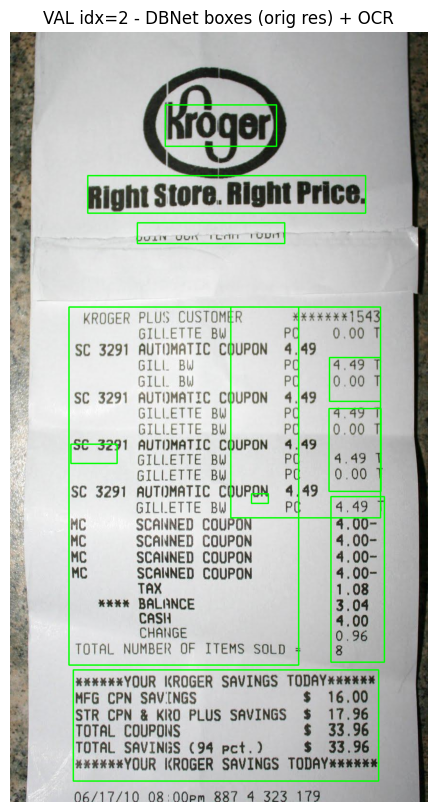

🔎 Validation sample idx=2
[0] bbox_orig=(131, 1325, 634, 231)  text='#*****your I(roger SAVINGS TOday****rr MFG CPN SAV [NGS 16,00 STR CPN 8 Kiro PLUS SAVINGS 5 17.96 TOTAL COUPONS $ 33. 96 TOTAL SAVINIS ( 94 Pct  $ 33. 96 #*xxx*your KKROGEr SAVINGS Today*xrrr*'
[1] bbox_orig=(666, 965, 111, 344)  text='4 49 T 4,00 - 4,00 - 4,00- 4.00- 1 , 08 3.04 4.00 0 96 8'
[2] bbox_orig=(501, 959, 35, 20)  text=''
[3] bbox_orig=(126, 856, 96, 40)  text='00 OL'
[4] bbox_orig=(662, 782, 108, 172)  text='4 49 0,00 4 49 0,00'
[5] bbox_orig=(663, 676, 106, 91)  text='4 49 0 00 T'
[6] bbox_orig=(458, 571, 311, 438)  text='R *******1543 PC 0,00 T JUPON 4.49 PC 4 49 T PC 0,00 T JUPON 4 49 PC 4 , 49 T PC 0,00 T JUPON 4 49 PC 4 49 PC 0 00 JUPON 4.49 PC 4 49'
[7] bbox_orig=(122, 571, 477, 744)  text='KROGER PLUS CUSTOMER GILLETTE BW PC SC 3291 AUTUMATIC coupon 4 GILL BW PC GILL BW PC SC 3291 AUTIMATIc coupon 4 GILLETTE BW PC GILLETTE BW PC SC 3291 AUTIMATIC coupon 4 GILLETTE BW PC GILLETTE BW PC SC 3291 AUTIM

In [ ]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import easyocr

# Make sure we are on the right device and in eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model architecture and weights from the path
best_model = DBNet()  # Define the architecture (DBNet or any other model you are using)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))  # Load model weights
best_model = best_model.to(device)  # Move model to the device (GPU or CPU)
best_model.eval()  # Set model to evaluation mode

# Initialize EasyOCR reader (English, GPU if available)
reader = easyocr.Reader(['en'], gpu=torch.cuda.is_available())
print("EasyOCR initialized. GPU:", torch.cuda.is_available())

def predict_text_from_val_idx_fullres(idx, prob_thresh=0.5, min_box_area=300, upscale_factor=2):
    """
    Use DBNet on resized image but run OCR on original full-resolution invoice.
    """
    # 1) ORIGINAL validation example (full-res PIL)
    ex = val_hf[idx]
    pil_img = ex["image"]  # full-resolution PIL image
    orig_w, orig_h = pil_img.size
    print(f"Original Image Size: {orig_w}x{orig_h}")

    # 2) Resize for model (same as DBNetDataset)
    model_h = train_ds.target_h  # e.g., 640
    model_w = train_ds.target_w  # e.g., 480
    pil_resized = pil_img.resize((model_w, model_h), Image.BILINEAR)
    img_tensor = transforms.ToTensor()(pil_resized).unsqueeze(0).to(device)  # [1,3,H,W]

    # 3) Run model
    with torch.no_grad():
        logits = best_model(img_tensor)  # [1,1,H/32,W/32]
        logits_up = F.interpolate(
            logits,
            size=(model_h, model_w),
            mode="bilinear",
            align_corners=False
        )  # [1,1,H,W]
        prob = torch.sigmoid(logits_up)[0, 0].cpu().numpy()  # [H,W]

    # 4) Threshold in model space
    mask_small = (prob >= prob_thresh).astype("uint8") * 255  # [H,W]

    # 5) Find contours (model space)
    contours, _ = cv2.findContours(mask_small, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Contours found: {len(contours)}")

    # 6) Original image in BGR for drawing / cropping
    img_orig_bgr = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

    detected_texts = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        if area < min_box_area:
            continue

        # Map (x,y,w,h) from model-space to original-space
        x0 = int(x * orig_w / model_w)
        y0 = int(y * orig_h / model_h)
        x1 = int((x + w) * orig_w / model_w)
        y1 = int((y + h) * orig_h / model_h)

        # Clamp to valid image bounds
        x0 = max(0, min(orig_w - 1, x0))
        y0 = max(0, min(orig_h - 1, y0))
        x1 = max(0, min(orig_w, x1))
        y1 = max(0, min(orig_h, y1))

        if x1 <= x0 or y1 <= y0:
            continue

        crop = img_orig_bgr[y0:y1, x0:x1]

        # Optional: upscale crop for easier OCR on small/blurred text
        if upscale_factor is not None and upscale_factor > 1:
            crop = cv2.resize(
                crop,
                (0, 0),
                fx=upscale_factor,
                fy=upscale_factor,
                interpolation=cv2.INTER_CUBIC
            )

        # 7) OCR on high-res crop
        ocr_result = reader.readtext(crop, detail=0)  # list of strings
        if not ocr_result:
            continue

        print(f"OCR result for crop: {ocr_result}")
        text = " ".join(ocr_result)
        detected_texts.append({
            "bbox_orig": (x0, y0, x1 - x0, y1 - y0),
            "text": text
        })

    # 8) Visualize green boxes on ORIGINAL invoice
    vis = img_orig_bgr.copy()
    for dt in detected_texts:
        x, y, w, h = dt["bbox_orig"]
        cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 255, 0), 2)

    vis_rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.title(f"VAL idx={idx} - DBNet boxes (orig res) + OCR")
    plt.imshow(vis_rgb)
    plt.axis("off")
    plt.show()

    print(f"🔎 Validation sample idx={idx}")
    for i, dt in enumerate(detected_texts):
        print(f"[{i}] bbox_orig={dt['bbox_orig']}  text={dt['text']!r}")

    full_text = "\n".join([dt["text"] for dt in detected_texts])
    return detected_texts, full_text


# Example: run on one validation invoice
det_list, full_txt = predict_text_from_val_idx_fullres(idx=2, prob_thresh=0.5)
print("\n========== FULL PREDICTED TEXT (VAL idx=5, FULL-RES OCR) ==========")
print(full_txt)


***Metrics Evaluation***

In [ ]:
import torch
import numpy as np
from tqdm import tqdm

def evaluate_pixel_metrics_stream(model, dataloader, H, W, thresh=0.5, device=device):
    model.eval()
    TP = FP = FN = TN = 0
    with torch.no_grad():
        for imgs, masks in tqdm(dataloader):
            imgs = imgs.to(device)
            masks = masks.to(device).long()  # [B,1,H,W] {0,1}

            logits = model(imgs)
            logits_up = torch.nn.functional.interpolate(
                logits, size=(H, W), mode='bilinear', align_corners=False)
            probs = torch.sigmoid(logits_up)  # [B,1,H,W]

            preds = (probs >= thresh).long()

            TP += int(((preds == 1) & (masks == 1)).sum().cpu().item())
            FP += int(((preds == 1) & (masks == 0)).sum().cpu().item())
            FN += int(((preds == 0) & (masks == 1)).sum().cpu().item())
            TN += int(((preds == 0) & (masks == 0)).sum().cpu().item())

    # metrics
    precision = TP / (TP + FP + 1e-12)
    recall    = TP / (TP + FN + 1e-12)
    f1        = 2 * precision * recall / (precision + recall + 1e-12)
    iou       = TP / (TP + FP + FN + 1e-12)
    return precision, recall, f1, iou

p0, r0, f0, iou0 = evaluate_pixel_metrics_stream(best_model, val_loader, H, W, thresh=0.5)
print(f"At thr=0.50 -> Precision: {p0:.4f}, Recall: {r0:.4f}, F1: {f0:.4f}, IoU: {iou0:.4f}")


100%|██████████| 409/409 [00:28<00:00, 14.28it/s]

At thr=0.50 -> Precision: 0.8401, Recall: 0.8150, F1: 0.8274, IoU: 0.7056
